# 🧠🩻 DICOM Pixel & Metadata De-Identification (MIDI-B)

In this notebook, we demonstrate **end-to-end de-identification of DICOM files**, covering both **pixel data** 🖼️ and **metadata** 🧾 using **Visual NLP**, **Spark OCR**, and **Healthcare NLP** models.

The approach follows the methodology described in the blog post below, and extends it to support **full MIDI-B–compliant evaluation** across both pixel and metadata domains:

🔗 https://medium.com/john-snow-labs/de-identifying-dicom-files-a-step-by-step-guide-with-john-snow-labs-visual-nlp-2c21b60f92a8

---

## 🔍 What This Notebook Covers

The pipeline is driven by a **strategy file (CSV)** that specifies how each DICOM tag should be handled:

- 🧬 Tags marked with **`cleanTag`** are routed through **NER-based dPHI detection**
- ⚙️ All other tags are processed using **rule-based and deterministic de-identification logic**
- 🖼️ Pixel-level PHI is detected and removed using **Visual NLP–based image de-identification**

This notebook focuses on a **complete Pixel + Metadata de-identification workflow**, aligned with the  
**MIDI-B (Medical Image De-Identification Benchmark)** guidelines.

---

## 📘 Notebook Workflow

The notebook is organized into the following steps:

### 1️⃣ Load DICOM Files  
📂 Read and inspect raw DICOM files (single-frame and multi-frame) from disk.

### 2️⃣ View Strategy Files  
📄 Examine the CSV strategy file that defines:
- Tag-level metadata actions  
- Pixel-level de-identification behaviour  

### 3️⃣ Run Pixel + Metadata De-Identification Pipeline  
🚀 Apply the combined pipeline to:
- Remove PHI from image pixels  
- Clean or transform sensitive metadata tags  
- Preserve required clinical and technical information  

### 4️⃣ Compare Original vs De-Identified Outputs  
🔎 Analyse differences between:
- Original vs cleaned metadata  
- Original vs de-identified pixel regions  

### 5️⃣ Extract PATIENT / UID Mappings  
🔗 Generate deterministic mappings to support:
- Longitudinal consistency  
- Controlled re-identification (when permitted)  
- MIDI-B validation  

### 7️⃣ Save De-Identified DICOMs to Disk  
💾 Persist fully de-identified DICOM files for downstream use, benchmarking, or deployment.

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Start Spark session

In [2]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_internal="6.2.2")

spark

Spark version: 3.5.0
Spark NLP version: 6.2.0
Spark NLP for Healthcare version: 6.2.0
Spark OCR version: 6.2.2rc1

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-af54f717-3b80-456c-bb75-6dfe79f16ba2;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.2.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	found com.g

## Import transformers and annotators

In [3]:
import os
import sys
import shutil 

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
from sparkocr.schemas import BinarySchema

from pyspark.ml import PipelineModel, Pipeline
from pyspark.sql.functions import *

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 6.2.0
Spark NLP internal version: 6.2.0
Spark OCR version: 6.2.2rc1


## Load Dicom Files

In [4]:
midib_root_path = './../data/dicom/midib/*.dcm'

dicom_df = spark.read.format("binaryFile").load(midib_root_path)

dicom_df

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|file:/workspace/D...|2025-12-18 12:45:43|8179050|[00 00 00 00 00 0...|
|file:/workspace/D...|2025-12-18 12:41:06|7022298|[00 00 00 00 00 0...|
+--------------------+-------------------+-------+--------------------+

## Load Strategy File

In [5]:
import pkg_resources
import pandas as pd

default_csv_path = pkg_resources.resource_filename('sparkocr', "resources/ocr/dicom/midi_b_strategy_ner.csv")

strategy_df = pd.read_csv(default_csv_path)

strategy_df.head()

Tags  VR                                 Name Status  \
0  (0008, 002A)  DT                 Acquisition DateTime    NaN   
1  (0008, 009C)  PN          Consulting Physician's Name    NaN   
2  (0008, 010D)  UI  Context Group Extension Creator UID    NaN   
3  (0010, 21D0)  DA                  Last Menstrual Date    NaN   
4  (0010, 21F0)  LO       Patient's Religious Preference    NaN   

                      Action Option  
0  shiftDateByRandomNbOfDays    NaN  
1                     remove    NaN  
2                     hashId    NaN  
3  shiftDateByRandomNbOfDays    NaN  
4                     remove    NaN

In [6]:
# all available actions in the present strategy file
strategy_df["Action"].unique()

array(['shiftDateByRandomNbOfDays', 'remove', 'hashId',
       'replaceWithRandomName', 'shiftUnixTimeStampRandom',
       'replaceWithLiteral', 'cleanTag', 'ensureTagExists',
       'patientHashId'], dtype=object)

# Dicom ( Pixel + Metadata ) De-Identification

### 🧾 DICOM Metadata De-Identification Pipeline

This section describes the **metadata-level de-identification pipeline** used to detect and remove **PHI embedded in DICOM metadata tags**.  
The pipeline combines **strategy-driven tag routing**, **Healthcare NLP**, **Zero-Shot NER**, and **rule-based pattern matching** to identify sensitive entities and generate **cleaned, PHI-safe metadata** while preserving DICOM structural integrity.

The behavior of the pipeline is fully controlled by a **strategy file (CSV)**, enabling configurable, auditable, and repeatable metadata de-identification.

---

#### ⚙️ Pipeline Overview

The metadata de-identification pipeline performs the following high-level steps:

1. Extract DICOM metadata from files
2. Route selected tags for NLP-based PHI detection using a strategy file
3. Convert tag text into NLP-ready documents
4. Detect PHI using deep-learning NER, zero-shot NER, and regex rules
5. Merge and filter detected PHI entities
6. Obfuscate sensitive metadata values and reconstruct cleaned metadata

The final output consists of **de-identified metadata representations** that can be written back into valid DICOM files.

In [7]:
def metadata_deid_pipeline(default_csv_path):
    
    dicom_to_metadata = DicomToMetadata() \
        .setInputCol("path") \
        .setOutputCol("metadata_original") \
        .setKeepInput(True) \
        .setExtractTagForNer(True) \
        .setTagMappingCol("tag_mapping") \
        .setTagCol("tag_text") \
        .setStrategyFile(default_csv_path)
    
    t_document_assembler = DocumentAssembler() \
        .setInputCol("tag_text") \
        .setOutputCol("t_document")
    
    t_sentencer = SentenceDetector()\
        .setInputCols(["t_document"])\
        .setOutputCol("t_sentence") \
        .setCustomBounds(["<dicom>"]) \
        .setUseCustomBoundsOnly(True)
    
    t_tokenizer = Tokenizer() \
        .setInputCols(["t_sentence"]) \
        .setOutputCol("t_token") \
        .setContextChars(["_", "^", "."])
    
    t_word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols(["t_sentence", "t_token"]) \
        .setOutputCol("t_embeddings")
    
    t_ner_deidentify_dl = MedicalNerModel.pretrained("ner_deidentify_dl", "en", "clinical/models") \
        .setInputCols("t_sentence", "t_token", "t_embeddings") \
        .setOutputCol("t_ner_deidentify_dl")
    
    t_ner_deidentify_dl_ner_converter = NerConverterInternal() \
        .setInputCols(["t_sentence", "t_token", "t_ner_deidentify_dl"]) \
        .setOutputCol("t_ner_deidentify_dl_ner_chunk") \
        .setWhiteList(["DOCTOR", "PATIENT", "ORGANIZATION", "LOCATION-OTHER", "COUNTRY", "CITY", "STATE", "STREET", "ZIP"]) \
        .setThreshold(0.82)
    
    labels = ["CITY", "COUNTRY", "DATE", "DOCTOR", "HOSPITAL", "ORGANIZATION", "PATIENT", "PHONE", "PROFESSION", "STATE", "STREET", "ZIP"]
    t_zeroshot_ner_deid_subentity_docwise_large = PretrainedZeroShotNER().pretrained("zeroshot_ner_deid_subentity_docwise_large", "en", "clinical/models") \
        .setInputCols("t_sentence", "t_token") \
        .setOutputCol("t_zeroshot_ner_deid_subentity_docwise_large") \
        .setPredictionThreshold(0.90) \
        .setLabels(labels)
    
    t_zeroshot_ner_deid_subentity_docwise_large_ner_converter = NerConverterInternal()\
        .setInputCols("t_sentence", "t_token", "t_zeroshot_ner_deid_subentity_docwise_large")\
        .setOutputCol("t_zeroshot_ner_deid_subentity_docwise_large_ner_chunk")
    
    codes = [
        "AK","TSARH","BH","FGH","PH","WGMC","GVH","MCH","MJM","SS","CWASH","RASC","CMCH","FMCC",
        "TLM","RMABCH","EBMC","MM","SCH","WM","AAARM","HM","WHAYCC","BGH","NH","MDCH","DSAPCC",
        "MBARCH","CMC","MLASGH","FWARMC","GFASCC","JCH","MKAAH","WNGH","PAAHMC","WBARCC","HG",
        "WG","HMCC","CHC","HCCH","CHAJH","PQACH","MSCH","MJH","HMAJMC","DHCH","GGAMH","LGMC",
        "HRG","HGAWC","WJADC","DC","LCH","WSC","BJAHGH","SSABM","HSG","HHAMM","BGCC","JASGH",
        "HWGH","AMC","KM","RS","DL","CL","LS","KP","CV","AR","CB","SE","ES","JD","CCH","DBAMCH",
        "MSAMM","SBAJH","RTAJCC","BASM","VHG","HPCC","HPAOM","AL","RD","CW","DTAMG","SCASM",
        "HFACG","YPH","MWM","SL","SW","VAGH","SJ", "AH", "CH", "JCASCH", "LBAWCH","ECC", "NRALG",
        "MWG", "WBAACH", "FBH", "CAAFMC", "BYARMC"
    ]
    
    pattern = r"\b(" + "|".join(codes) + r")\b"
    
    t_regex_matcher = RegexMatcher() \
        .setInputCols("t_sentence") \
        .setOutputCol("t_regex") \
        .setRules([
            # Match known hospital or facility codes (from predefined list)
            pattern + ";CODES",
            # Match professional titles like Dr., DR., dr
            r"\b[Dd][Rr]\b\.?;PROFESSION",
            # Match numeric IDs in format: 123.456.7890x123
            r"\d{3}\.\d{3}\.\d{4}x\d{3};ID",
            # Match compact date-like numeric patterns (YYMMDD etc.)
            r"\b(?:\d{2}(0[1-9]|1[0-2])(0[1-9]|[12]\d|3[01]))\b;DATE",
            # Match phone-like pattern with parentheses and extension,
            # e.g. (151)265-4464x20 — but we tag it as DATE as per your request
            r"\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}(?:x\d{1,5})?;PHONE",
            # Match SSN-style numeric pattern (e.g. 300-45-3175) → labeled as DATE
            r"\b\d{3}-\d{2}-\d{4}\b;DATE"]) \
        .setDelimiter(";") 
    
    t_chunk_converter = ChunkConverter()\
        .setInputCols("t_regex")\
        .setOutputCol("t_regex_ner_chunk")
    
    t_chunk_merger = ChunkMergeApproach()\
        .setInputCols('t_regex_ner_chunk', 't_ner_deidentify_dl_ner_chunk', 't_zeroshot_ner_deid_subentity_docwise_large_ner_chunk')\
        .setOutputCol('t_merged_ner_chunk')\
        .setMergeOverlapping(True)
    
    filter_chunk = ["US", "MR BREAS", "MR BREAST BILAT", "MR BREASTUNI", "MIEDNICA", "WWO", "THINS", 
          "3D Rendering", "MAMMO", "CT", "DCE", "CA", "MC prostaat kliniek detectie-mc"]
    
    t_chunk_filterer = ChunkFilterer() \
      .setInputCols(["t_sentence","t_merged_ner_chunk"]) \
      .setOutputCol("t_filtered") \
      .setCriteria("isin") \
      .setFilterValue("result") \
      .setBlackList(filter_chunk)
    
    deid_obfuscated = DeIdentification() \
        .setInputCols(["t_sentence", "t_token", "t_filtered"]) \
        .setOutputCol("deid_documents") \
        .setMode("deid")
    
    pipeline = Pipeline(stages=[
        dicom_to_metadata,
        t_document_assembler,
        t_sentencer,
        t_tokenizer,
        t_word_embeddings,
        t_ner_deidentify_dl,
        t_ner_deidentify_dl_ner_converter,
        t_zeroshot_ner_deid_subentity_docwise_large,
        t_zeroshot_ner_deid_subentity_docwise_large_ner_converter,
        t_regex_matcher,
        t_chunk_converter,
        t_chunk_merger,
        t_chunk_filterer,
        deid_obfuscated
    ])

    return pipeline

### 🖼️ DICOM Pixel De-Identification Pipeline

This section describes the **pixel-level de-identification pipeline** used to detect and remove **PHI embedded directly in DICOM image pixels**. The pipeline combines **Visual NLP**, **OCR**, **Zero-Shot NER**, and **rule-based pattern matching** to accurately localize sensitive information and return precise pixel coordinates for redaction.

The pipeline supports **CPU and GPU execution**, enabling scalable processing across large imaging datasets.

---

#### ⚙️ Pipeline Overview

The pixel de-identification pipeline performs the following high-level steps:

1. Convert DICOM files into images
2. Detect text regions within the image
3. Extract text with positional information (OCR)
4. Identify PHI entities using NER and regex rules
5. Map detected PHI entities back to image coordinates


In [8]:
def pixel_deid_pipeline(useGPU):

    dicom_to_image = DicomToImageV3() \
        .setInputCols(["path"]) \
        .setOutputCol("image_raw") \
        .setKeepInput(True)
    
    text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
        .setInputCol("image_raw") \
        .setOutputCol("text_regions") \
        .setScoreThreshold(0.7) \
        .setWithRefiner(True) \
        .setUseGPU(useGPU) \
        .setWidth(0)
    
    ocr = ImageToTextV2.pretrained("ocr_large_printed_v2_opt", "en", "clinical/ocr") \
        .setRegionsColumn("text_regions") \
        .setInputCols(["image_raw"]) \
        .setOutputCol("text") \
        .setOutputFormat("text_with_positions") \
        .setGroupImages(False) \
        .setKeepInput(False) \
        .setUseGPU(useGPU) \
        .setUseCaching(True) \
        .setBatchSize(4)
    
    p_document_assembler = DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("p_document") \
        .setCleanupMode("disabled")
    
    p_sentencer = SentenceDetector()\
        .setInputCols(["p_document"])\
        .setOutputCol("p_sentence") \
        .setCustomBounds(["\n"]) \
        .setUseCustomBoundsOnly(False)
    
    p_tokenizer = Tokenizer() \
        .setInputCols(["p_sentence"]) \
        .setOutputCol("p_token")
    
    labels = ["DATE", "DOCTOR", "PATIENT"]
    p_zeroshot_ner_deid_subentity_docwise_medium = PretrainedZeroShotNER().pretrained("zeroshot_ner_deid_subentity_docwise_medium", "en", "clinical/models")\
        .setInputCols("p_sentence", "p_token")\
        .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium")\
        .setPredictionThreshold(0.5)\
        .setLabels(labels)
    
    p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter = NerConverterInternal()\
        .setInputCols("p_sentence", "p_token", "p_zeroshot_ner_deid_subentity_docwise_medium")\
        .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
        .setThreshold(0.80)
    
    p_regex_matcher = RegexMatcher()\
        .setInputCols("p_document")\
        .setOutputCol("p_regex")\
        .setRules([
            r"\[\s*([MFU])\s*\](?:\s|\b|$);GENDER",
            r"\b(?:JT|SWU|JKR|MWF|ICG|NKF|YH|TJN|LEITO|ACO|CEF|CMS|JGR|MSS|MHS|ROC|LM|RCN|FTA|MGO|LACI|VV|HA|TR|CJA)\b;CODE"]) \
        .setDelimiter(";")
    
    p_chunk_converter = ChunkConverter()\
        .setInputCols("p_regex")\
        .setOutputCol("p_regex_chunk")
    
    p_chunk_merger = ChunkMergeApproach()\
        .setInputCols('p_regex_chunk', "p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk")\
        .setOutputCol('p_merged_ner_chunk')\
        .setMergeOverlapping(True)
    
    position_finder = PositionFinder() \
        .setInputCols("p_merged_ner_chunk") \
        .setOutputCol("coordinates") \
        .setPageMatrixCol("positions") \
        .setSmoothCoordinates(True)

    pipeline = Pipeline(stages=[
        dicom_to_image,
        text_detector,
        ocr,
        p_document_assembler,
        p_sentencer,
        p_tokenizer,
        p_zeroshot_ner_deid_subentity_docwise_medium,
        p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter,
        p_regex_matcher,
        p_chunk_converter,
        p_chunk_merger,
        position_finder
    ])

    return pipeline

### 🧩 Complete DICOM Pixel & Metadata De-Identification

This pipeline performs **end-to-end DICOM de-identification** by combining **metadata PHI removal** and **pixel-level PHI redaction** into a single Spark ML workflow.

The cleaned metadata is applied back to the original DICOM using `DicomMetadataDeidentifier`, and detected pixel regions are redacted using `DicomDrawRegions`, producing a **fully de-identified DICOM file**. Metadata is then re-extracted from both the original and final DICOMs to support **validation, auditing, and comparison**.

In [9]:
dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["path"]) \
    .setOutputCol("dicom_metadata_cleaned") \
    .setTagMappingCol("tag_mapping") \
    .setKeepInput(True) \
    .setTagCleanedCol("deid_documents") \
    .setStrategyFile(default_csv_path)

draw_regions = DicomDrawRegions() \
    .setInputCol("dicom_metadata_cleaned") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom_final") \
    .setAggCols(["path"]) \
    .setKeepInput(False)

extract_original_tag = DicomToMetadata() \
    .setInputCol("path") \
    .setOutputCol("metadata_original") \
    .setKeepInput(True) \
    .setExtractTagForNer(False) \
    .setStrategyFile(default_csv_path)

extract_final_tag = DicomToMetadata() \
    .setInputCol("dicom_final") \
    .setOutputCol("metadata_cleaned") \
    .setKeepInput(True) \
    .setExtractTagForNer(False) \
    .setStrategyFile(default_csv_path)

stages = [
    metadata_deid_pipeline(default_csv_path),
    pixel_deid_pipeline(useGPU = False),
    dicom_deidentifier,
    draw_regions,
    extract_original_tag,
    extract_final_tag
]

dicom_pipeline = Pipeline(stages=stages)                

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ]embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
ner_deidentify_dl download started this may take some time.
Approximate size to download 14.1 MB
[ | ]ner_deidentify_dl download started this may take some time.
Approximate size to download 14.1 MB
[ / ]Download done! Loading the resource.
[ — ]

2025-12-19 14:34:10.441890: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 14:34:10.521354: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_de

[OK!]
zeroshot_ner_deid_subentity_docwise_large download started this may take some time.
Approximate size to download 1.5 GB
[ | ]zeroshot_ner_deid_subentity_docwise_large download started this may take some time.
Approximate size to download 1.5 GB
Download done! Loading the resource.
[OK!]
image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
Download done! Loading the resource.


ocr_large_printed_v2_opt download started this may take some time.
Approximate size to download 931 MB
Download done! Loading the resource.
zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
[ | ]zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
Download done! Loading the resource.
[OK!]


In [10]:
result = dicom_pipeline.fit(dicom_df).transform(dicom_df).cache()

result.columns

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


['dicom_final', 'exception', 'path', 'metadata_original', 'metadata_cleaned']

### Extract Original Vs Cleaned Metadata to Pandas DF

In [11]:
collect_result = []

for item in result.select("path", "metadata_original", "metadata_cleaned").toLocalIterator():

    data = item.asDict()

    metadata_original = json.loads(data["metadata_original"])
    metadata_cleaned = json.loads(data["metadata_cleaned"])

    for item in metadata_original.keys():
        original_value = metadata_original[item]["value"]
        cleaned_value = metadata_cleaned[item]["value"]
        
        value_changed = False if original_value == cleaned_value else True
        
        collect_result.append([data["path"], item, metadata_original[item]["vr"], original_value, cleaned_value, value_changed])

14:34:52, INFO Run DicomToMetadata                                  (0 + 2) / 2]
14:34:53, INFO Run DicomToMetadata
14:34:58, INFO DicomToMetadata : Total Rules Extracted 198
14:34:58, INFO DicomToMetadata : Total cleanTag Action Found : 14
14:34:58, INFO DicomToMetadata : Returning Metadata, Document Object and Tag Mapping for NER
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.3.185.0.2.0801206.6.512.1221786140775342924'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.3.185.0.2.0801206.6.512.1530417802811153775'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserW

Using CPUs


14:35:07, INFO Run DicomToImageV3
14:35:07, INFO Run DicomToImageV3
14:35:13, INFO DicomToImageV3: Number of frames: 1
14:35:13, INFO DicomToImageV3: Number of frames: 1
14:35:13, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.11/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 191, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self, group)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
raise AttributeError(
AttributeError: Unable to convert the overlay data as the following required elements are missing from the dataset: OverlayData, OverlayBitsAllocated, OverlayRows, OverlayColumns
14:35:13, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.11/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 191, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self,

Using CPUs


14:35:45, INFO Run DicomMetadataDeidentifier
14:35:45, INFO Run DicomMetadataDeidentifier
14:35:48, INFO DicomMetadataDeidentifier : Invalid Option : '' For Tag : '0008002A' And VR : 'DT'. Using Random instead.
14:35:48, INFO DicomMetadataDeidentifier : Updating Tag '0008002A' VR 'DT'
14:35:48, INFO DicomMetadataDeidentifier : Tag '0008009C' Present in Strategy file but missing in Dicom.
14:35:48, INFO DicomMetadataDeidentifier : Tag '0008010D' Present in Strategy file but missing in Dicom.
14:35:48, INFO DicomMetadataDeidentifier : Invalid Option : '' For Tag : '001021D0' And VR : 'DA'. Using Random instead.
14:35:48, INFO DicomMetadataDeidentifier : Updating Tag '001021D0' VR 'DA'
14:35:48, INFO DicomMetadataDeidentifier : Tag '001021F0' Present in Strategy file but missing in Dicom.
14:35:48, INFO DicomMetadataDeidentifier : Tag '0018700C' Present in Strategy file but missing in Dicom.
14:35:48, INFO DicomMetadataDeidentifier : Updating Tag '0020000D' VR 'UI'
14:35:48, INFO DicomMet

In [12]:
columns = ["File", "Tag", "VR", "Original_Value", "Cleaned_Value", "Is_Changed"]

metadata_result_df = pd.DataFrame(collect_result, columns=columns)
metadata_result_df.head(5)

File       Tag  VR  \
0  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080005  CS   
1  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080008  CS   
2  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080016  UI   
3  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080018  UI   
4  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080020  DA   

                                  Original_Value  \
0                                     ISO_IR 100   
1                          [ORIGINAL, PRIMARY, ]   
2                    1.2.840.10008.5.1.4.1.1.1.1   
3  2.3.185.0.2.0801206.6.512.1221786140775342924   
4                                       20190526   

                                  Cleaned_Value  Is_Changed  
0                                    ISO_IR 100       False  
1                         [ORIGINAL, PRIMARY, ]       False  
2                   1.2.840.10008.5.1.4.1.1.1.1       False  
3  2.25.130377398866551351689158762623323288883        True  
4                                      20190330        True

### Filter All Tags That are DeIdentified

In [13]:
metadata_result_df[metadata_result_df["Is_Changed"] == True].head(5)

File       Tag  VR  \
3  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080018  UI   
4  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080020  DA   
5  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080021  DA   
6  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080022  DA   
7  file:/workspace/DICOM_WORKSHOP/NEW_NBS/midib/T...  00080023  DA   

                                  Original_Value  \
3  2.3.185.0.2.0801206.6.512.1221786140775342924   
4                                       20190526   
5                                       20190526   
6                                       20190526   
7                                       20190526   

                                  Cleaned_Value  Is_Changed  
3  2.25.130377398866551351689158762623323288883        True  
4                                      20190330        True  
5                                      20190405        True  
6                                      20190404        True  
7                                      20190514        True

## Extract UID/Patiend ID Mapping

In [14]:
from sparkocr.utils import generate_dicom_mapping

help(generate_dicom_mapping)

Help on function generate_dicom_mapping in module sparkocr.utils:

generate_dicom_mapping(df, original_col, final_col)
    Return mapping of old and new dicom identifiers.
    
    :param df : Dataframe containing original and cleaned metadata
    :param original_col : Dataframe column containing original metadata
    :param final_col : Dataframe column containing cleaned metadata
    :return {"uid_mapping" : {old_uid:new_uid}, "patient_mapping" : {old_patid:new_patid}



In [15]:
mapping_result = generate_dicom_mapping(result, "metadata_original", "metadata_cleaned")

columns = ["id_old", "id_new"]

uid_mapping = pd.DataFrame(list(mapping_result["uid_mapping"].items()), columns=columns)

uid_mapping.head(5)

id_old  \
0                    1.2.840.10008.5.1.4.1.1.1.1   
1  2.3.185.0.2.0801206.6.512.1221786140775342924   
2  2.3.185.0.2.0801206.6.512.1530417802811153775   
3  2.3.185.0.2.0801206.6.512.1696618440938865491   
4  2.3.185.0.2.0801206.6.512.1517291030850877420   

                                         id_new  
0                   1.2.840.10008.5.1.4.1.1.1.1  
1  2.25.130377398866551351689158762623323288883  
2   2.25.94627344826000112534085906369516834805  
3   2.25.70571521897336622285826091149294726595  
4  2.25.146107250882657279873475188628760276109

In [16]:
columns = ["id_old", "id_new"]

patient_mapping = pd.DataFrame(list(mapping_result["patient_mapping"].items()), columns=columns)

patient_mapping.head(20)

id_old      id_new
0  2063640840  1512113109
1   913829086   131119190

## Pixel DeIdentification Result

/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.3.185.0.2.0801206.6.512.1221786140775342924'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


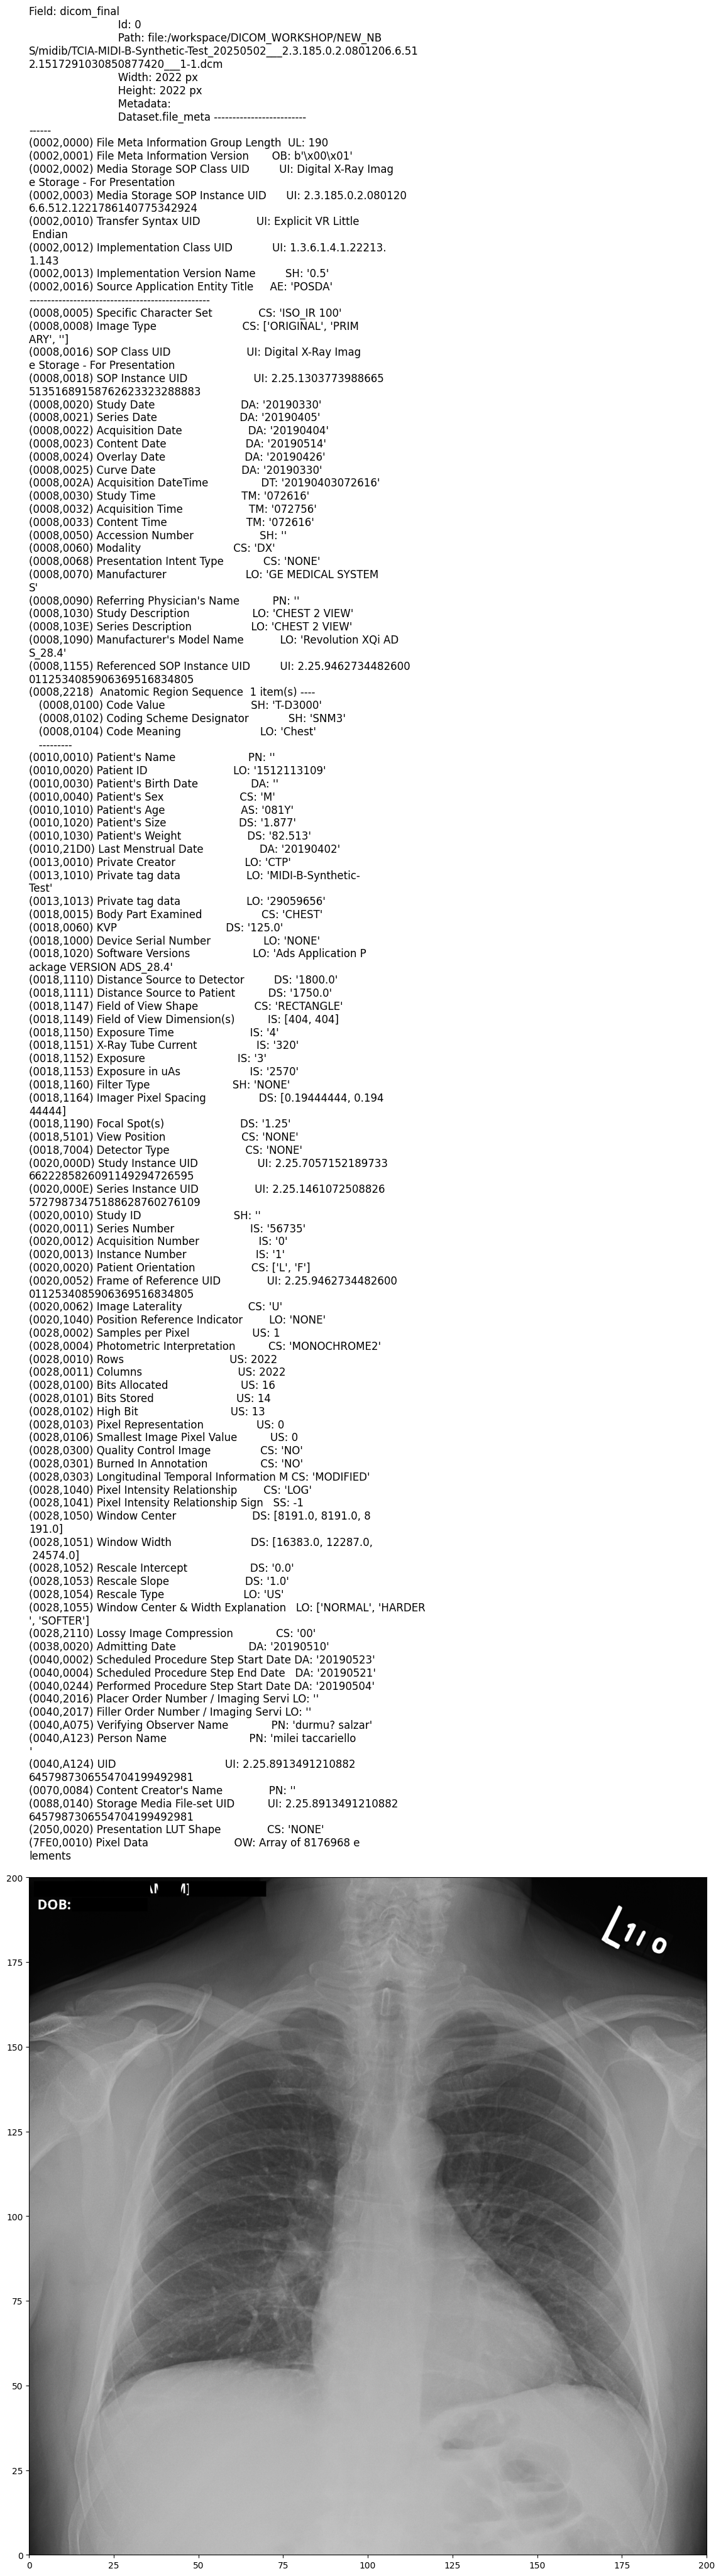

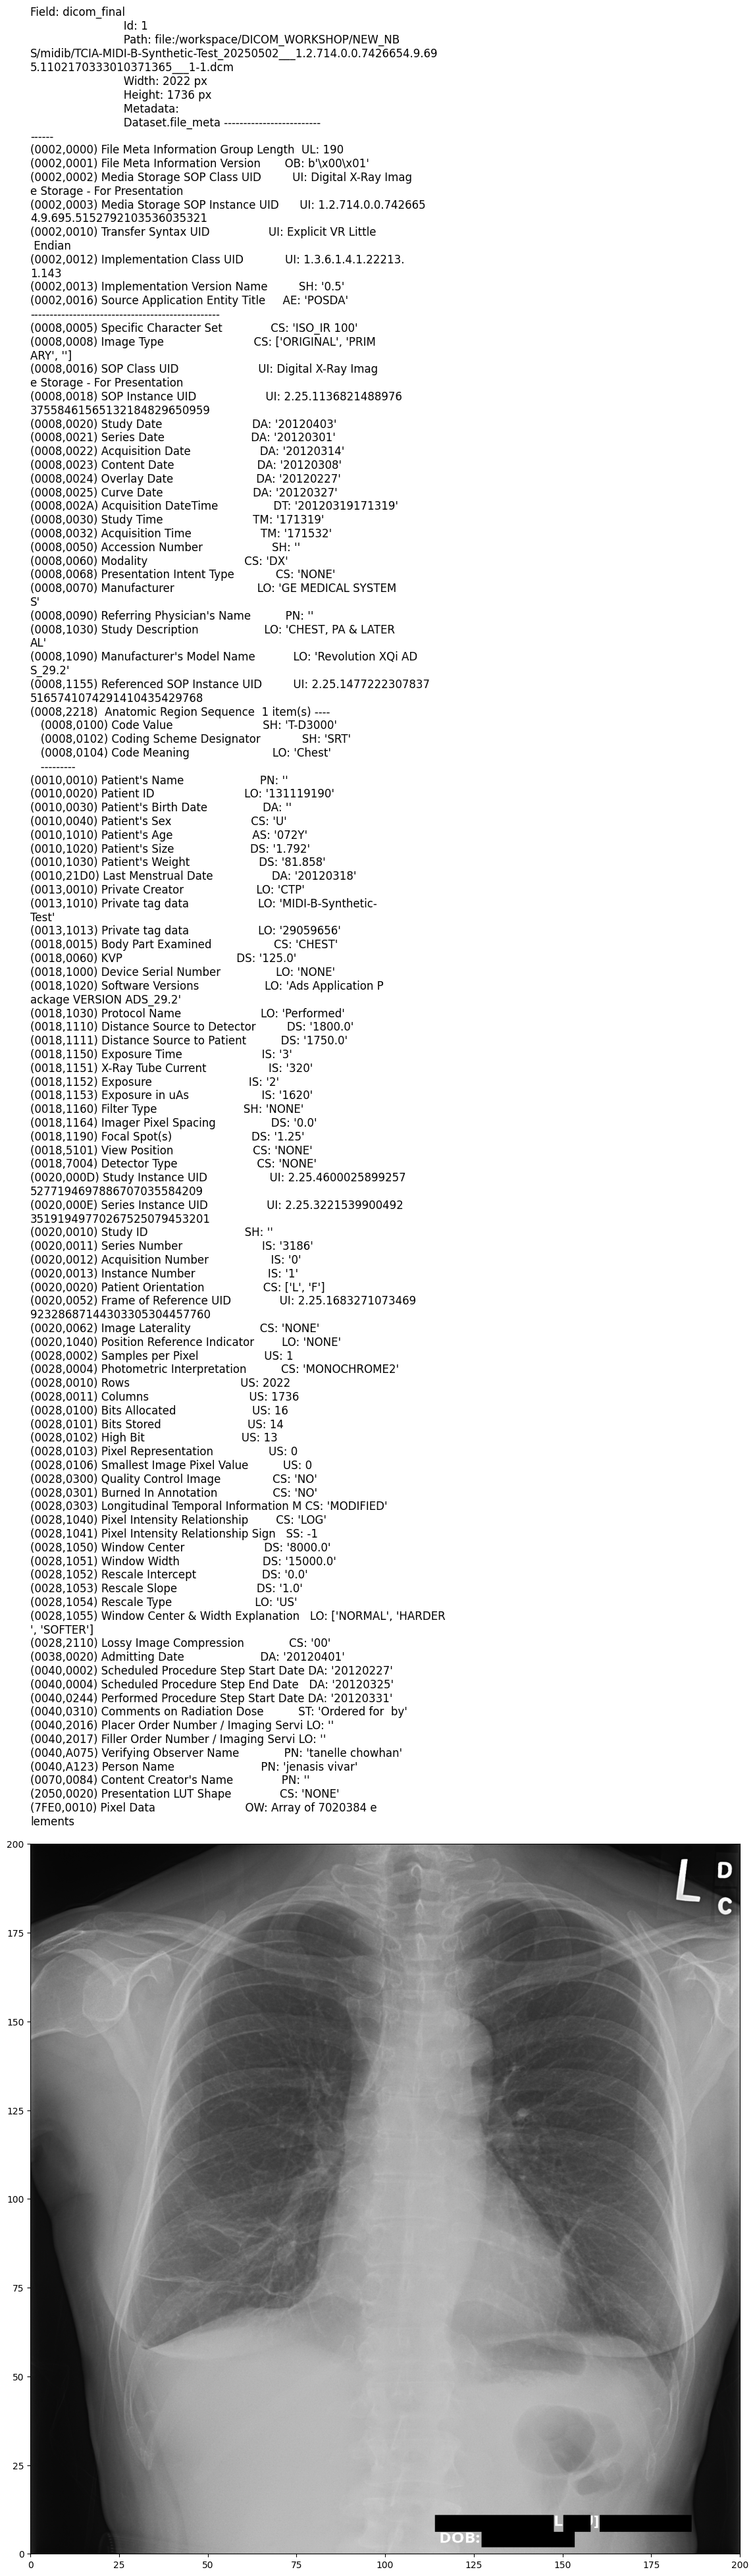

In [17]:
display_dicom(result, "dicom_final")

## Save Dicom File To Disk

In [18]:
root_path = "./dicom_deid_output"

os.makedirs(root_path, exist_ok=True)

for item in result.select("path", "dicom_final").toLocalIterator():
    data = item.asDict()
    filename = os.path.basename(data["path"])

    file_out_path = os.path.join(root_path, filename)

    with open(file_out_path, "wb") as dicom_out:
        dicom_out.write(data["dicom_final"])

In [19]:
shutil.rmtree(root_path)